In [2]:
import pandas as pd 
import matplotlib.pyplot as plt
import re
from collections import Counter
from nltk.corpus import stopwords
import nltk
from wordcloud import WordCloud
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, Dataset
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, roc_curve, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import seaborn as sns
from sklearn.metrics import classification_report, accuracy_score
from torch.optim.lr_scheduler import StepLR
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from torch.optim.lr_scheduler import ReduceLROnPlateau
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import KFold

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\panha\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\panha\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\panha\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\panha\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [3]:
df = pd.read_csv('dataset_tweets_preprocessed2.csv')
df['processed_text_str'] = df['processed_text_str'].astype(str)
df

,target,text,processed_text_str
0,0,"['thats', 'bummer', 'shoulda', 'got', 'david',...",thats bummer shoulda got david carr third day
1,0,"['upset', 'cant', 'update', 'facebook', 'texti...",upset cant update facebook texting might cry r...
2,0,"['dived', 'many', 'time', 'ball', 'managed', '...",dived many time ball managed save rest go bound
3,0,"['whole', 'body', 'feel', 'itchy', 'like', 'fi...",whole body feel itchy like fire
4,0,"['no', 'not', 'behaving', 'mad', 'cant', 'see']",no not behaving mad cant see
...,...,...,...
1599995,4,"['just', 'woke', 'no', 'school', 'best', 'feel...",just woke no school best feeling ever
1599996,4,"['thewdbcom', 'very', 'cool', 'hear', 'old', '...",thewdbcom very cool hear old walt interview â
1599997,4,"['ready', 'mojo', 'makeover', 'ask', 'detail']",ready mojo makeover ask detail
1599998,4,"['happy', 'th', 'birthday', 'boo', 'alll', 'ti...",happy th birthday boo alll time tupac amaru sh...


In [47]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1600000 entries, 0 to 1599999
Data columns (total 3 columns):
 #   Column              Non-Null Count    Dtype 
---  ------              --------------    ----- 
 0   target              1600000 non-null  int64 
 1   text                1600000 non-null  object
 2   processed_text_str  1600000 non-null  object
dtypes: int64(1), object(2)
memory usage: 36.6+ MB


## Data Preprocessing

### Data Cleaning

In [48]:
def preprocessed(text):
    text = text.lower()
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    text = re.sub(r'@\w+', '', text, flags=re.MULTILINE)
    text = re.sub(r'#\w+', '', text, flags=re.MULTILINE)
    text = re.sub(r'\d+', '', text, flags=re.MULTILINE)
    text = re.sub(r'[^\w\s]', '', text, flags=re.MULTILINE)
    text = re.sub(r'\s+', ' ', text, flags=re.MULTILINE).strip()

    return text

### Tokenize and Stop words removal

In [49]:
def tokenize_and_remove_stopwords(text):
    custom_stop_words = {'im', 'u', 'rt'}
    
    sentiment_critical = {
        'no', 'not', 'none', 'never', 'nothing', 'nowhere', 'neither', 'nor',
        'very', 'really', 'extremely', 'quite',
        'would', 'should', 'could', 'might', 'must',
        'but', 'however', 'although', 'though', 'despite', 'yet',
        'just', 'too', 'only', 'even', 'still'
    }
    
    tokens = word_tokenize(text)
  
    stop_words = set(stopwords.words('english')).union(custom_stop_words) - sentiment_critical
    tokens = [token for token in tokens if (token not in stop_words or token in sentiment_critical)]
    return tokens

### Words Lemmatization

In [50]:
def lemmitize_words(tokens):
    lemmatizer = WordNetLemmatizer()
    lemmatized_tokens = [lemmatizer.lemmatize(token) for token in tokens]
    return lemmatized_tokens

In [51]:
def preprocess_text(text):
    text = preprocessed(text)
    text = tokenize_and_remove_stopwords(text)
    text = lemmitize_words(text)
    return text

## Visualizing Sentiment Distribution

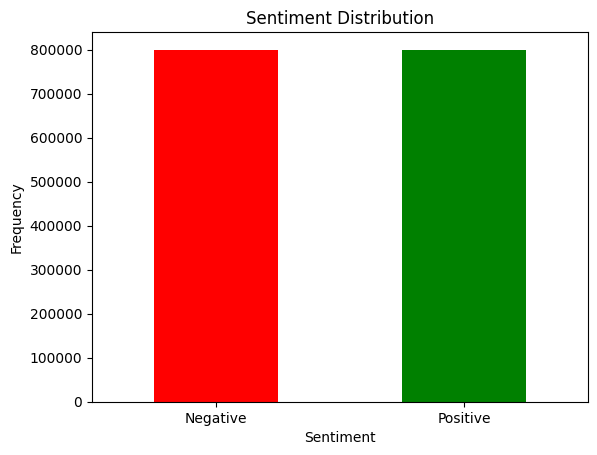

In [52]:
fig, ax = plt.subplots()
df['target'].value_counts().plot(kind='bar', color=['red', 'green'], ax=ax)
ax.set_title('Sentiment Distribution')
ax.set_xlabel('Sentiment')
ax.set_ylabel('Frequency')
plt.xticks(ticks=[0, 1], labels=['Negative', 'Positive'], rotation=0)
plt.show()

## Finding and Visualizing Common Words

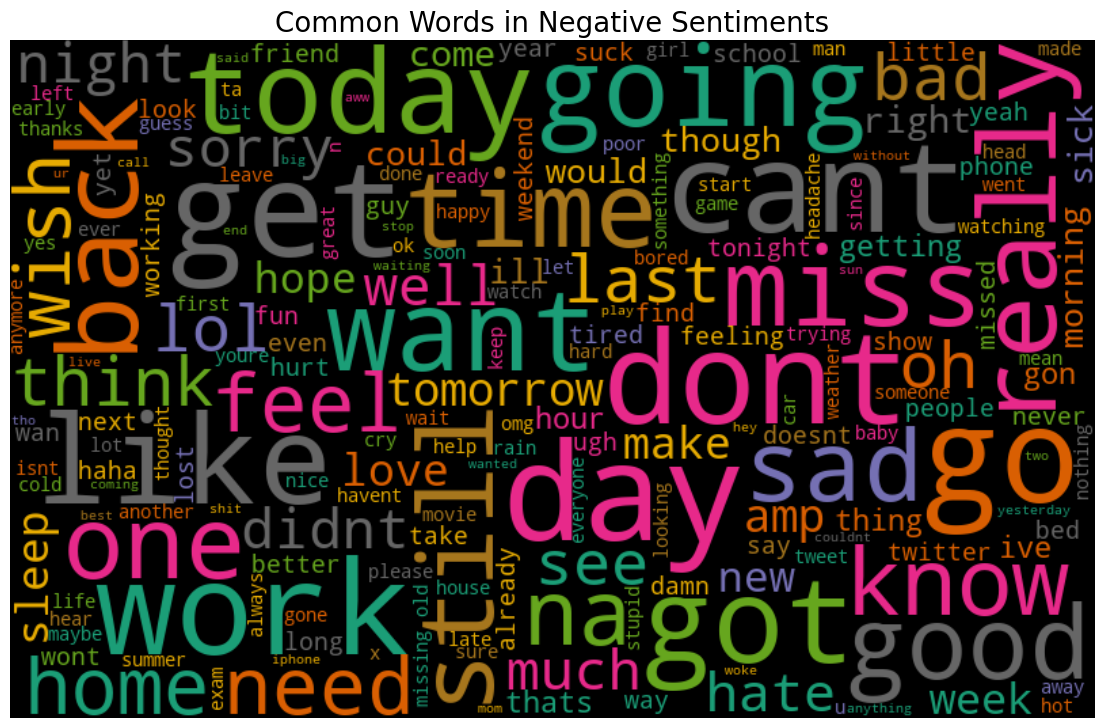

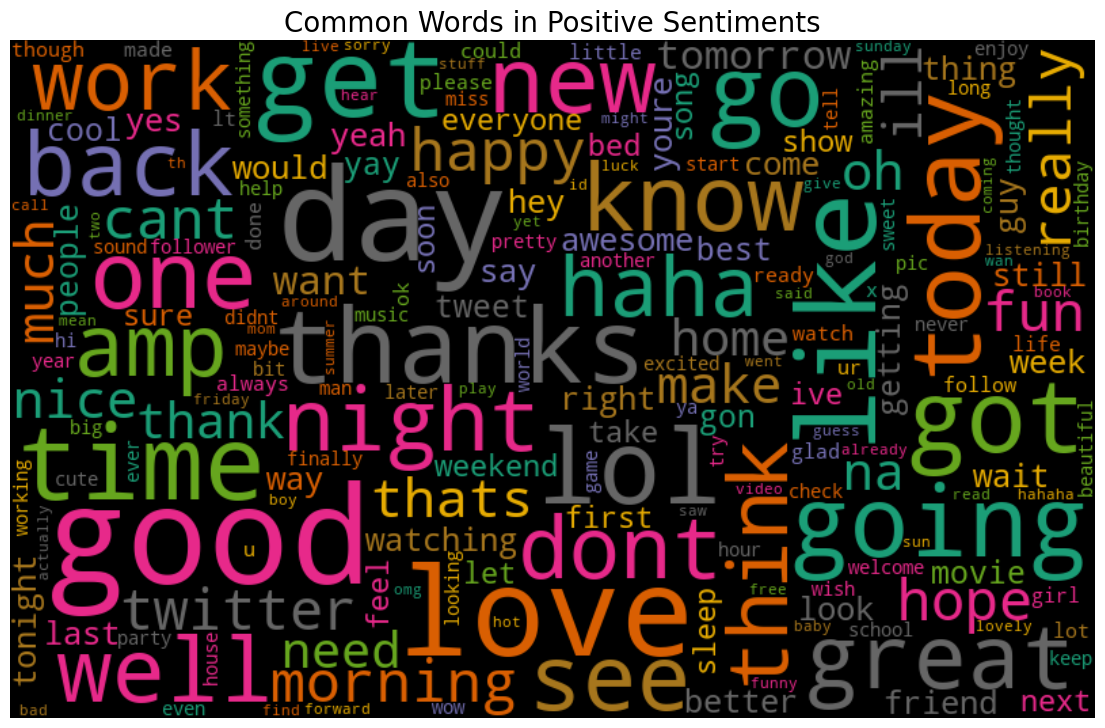

In [53]:
def get_common_words(texts):
    words = []
    for text in texts:
        words.extend(text.split())
    return Counter(words)

stop_words = set(stopwords.words('english'))

negative_words = get_common_words(df[df['target'] == 0]['processed_text_str'])
positive_words = get_common_words(df[df['target'] == 4]['processed_text_str'])

negative_common_words = Counter({word: count for word, count in negative_words.items() if word not in stop_words})
positive_common_words = Counter({word: count for word, count in positive_words.items() if word not in stop_words})

def generate_wordcloud(word_freq, title):
    wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=100, relative_scaling=0.5, colormap='Dark2').generate_from_frequencies(word_freq)
    plt.figure(figsize=(14, 10))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(title, fontsize=20)
    plt.show()

generate_wordcloud(negative_common_words, 'Common Words in Negative Sentiments')
generate_wordcloud(positive_common_words, 'Common Words in Positive Sentiments')

# Train a sentiment classification model

In [54]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


## **1. Logistic Regression**

In [55]:
class LogisticRegressionModel(nn.Module):
    def __init__(self, num_features):
        super(LogisticRegressionModel, self).__init__()
        self.linear = nn.Linear(num_features, 1)
    
    def forward(self, x):
        y_pred = torch.sigmoid(self.linear(x))
        return y_pred

# Dataset class for handling sparse matrices
class SparseDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y
    
    def __len__(self):
        return self.X.shape[0]
    
    def __getitem__(self, idx):
        x_dense = torch.from_numpy(self.X[idx].toarray().squeeze()).float()
        y_dense = torch.tensor(self.y[idx], dtype=torch.float32)
        return x_dense, y_dense

# EarlyStopping class to prevent overfitting
class EarlyStopping:
    def __init__(self, patience=5, verbose=False, delta=0):
        self.patience = patience
        self.verbose = verbose
        self.delta = delta
        self.best_score = None
        self.early_stop = False
        self.counter = 0
        self.best_loss = np.inf

    def __call__(self, val_loss, model, path='checkpoint_model.pth'):
        score = -val_loss
        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model, path)
        elif score < self.best_score + self.delta:
            self.counter += 1
            if self.verbose:
                print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model, path)
            self.counter = 0

    def save_checkpoint(self, val_loss, model, path):
        if self.verbose:
            print(f'Validation loss decreased ({self.best_loss:.6f} to {val_loss:.6f}). Saving model...')
        torch.save(model.state_dict(), path)
        self.best_loss = val_loss

# Train and validate the model
def train_validate_model(model, train_loader, val_loader, optimizer, criterion, scheduler, device, epochs, early_stopping):
    model.train()
    model.to(device)
    for epoch in range(epochs):
        total_loss = 0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs.squeeze(), labels)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        avg_loss = total_loss / len(train_loader)
        val_loss = validate_model(model, val_loader, criterion, device)
        print(f"Epoch {epoch+1}/{epochs}, Loss: {avg_loss:.4f}, Val Loss: {val_loss:.4f}")
        scheduler.step(val_loss)
        early_stopping(val_loss, model)
        if early_stopping.early_stop:
            print("Early stopping triggered.")
            break

# Validation function to compute loss
def validate_model(model, data_loader, criterion, device):
    model.eval()
    total_val_loss = 0
    with torch.no_grad():
        for inputs, labels in data_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs.squeeze(), labels)
            total_val_loss += loss.item()
    return total_val_loss / len(data_loader)

# Evaluate model performance
def evaluate_model(model, data_loader, device):
    model.eval()
    model.to(device)
    all_predictions = []
    all_labels = []
    all_probs = []
    with torch.no_grad():
        for inputs, labels in data_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs).squeeze()
            predicted_classes = outputs.round()
            all_predictions.extend(predicted_classes.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_probs.extend(outputs.cpu().numpy())

    accuracy = accuracy_score(all_labels, all_predictions)
    precision = precision_score(all_labels, all_predictions)
    recall = recall_score(all_labels, all_predictions)
    f1 = f1_score(all_labels, all_predictions)
    cm = confusion_matrix(all_labels, all_predictions)
    fpr, tpr, _ = roc_curve(all_labels, all_probs)
    roc_auc = auc(fpr, tpr)

    metrics = {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'confusion_matrix': cm,
        'roc_auc': roc_auc,
        'fpr': fpr,
        'tpr': tpr
    }
    return metrics

# Plot loss history
def plot_loss(loss_history):
    plt.figure(figsize=(10, 5))
    plt.plot(loss_history, label='Training Loss')
    plt.title('Loss History')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

# Plot confusion matrix
def plot_confusion_matrix(cm, classes):
    plt.figure(figsize=(10, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap='Blues', cbar=False, xticklabels=classes, yticklabels=classes)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix')
    plt.show()

# Plot ROC curve
def plot_roc_curve(fpr, tpr, roc_auc):
    plt.figure(figsize=(10, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.show()


## Bag of Words (BoW)

In [56]:
if __name__ == "__main__":
    df = pd.read_csv('dataset_tweets_preprocessed2.csv')
    df['target'] = df['target'].apply(lambda x: 0 if x == 0 else 1)
    df['processed_text_str'] = df['processed_text_str'].astype(str)

    vectorizer = CountVectorizer(max_features=10000, min_df=5, max_df=0.90)
    X = vectorizer.fit_transform(df['processed_text_str'])
    y = df['target'].values

    kfold = KFold(n_splits=5, shuffle=True, random_state=42)
    results = []
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    for fold, (train_idx, test_idx) in enumerate(kfold.split(X, y)):
        print(f"Starting Fold {fold + 1}")
        
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]  # Directly use numpy indexing

        train_dataset = SparseDataset(X_train, y_train)
        test_dataset = SparseDataset(X_test, y_test)

        train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
        test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

        model = LogisticRegressionModel(X_train.shape[1]).to(device)
        criterion = nn.BCELoss()
        optimizer = optim.SGD(model.parameters(), lr=0.5, weight_decay=0.01)
        scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)
        early_stopping = EarlyStopping(patience=5, verbose=True)

        train_validate_model(model, train_loader, test_loader, optimizer, criterion, scheduler, device, 15, early_stopping)
        metrics = evaluate_model(model, test_loader, device)
        print(f"Fold {fold+1}, Test Accuracy: {metrics['accuracy']:.4f}")

        # Append metrics for tracking
        results.append(metrics)

        # Plot Confusion Matrix
        print(f"Confusion Matrix for Fold {fold + 1}")
        plot_confusion_matrix(metrics['confusion_matrix'], classes=['Class 0', 'Class 1'])

        # Plot ROC Curve
        print(f"ROC Curve for Fold {fold + 1}")
        plot_roc_curve(metrics['fpr'], metrics['tpr'], metrics['roc_auc'])

    # Save the model
    torch.save(model.state_dict(), 'Trained_Model/logmodel_bow.pth')
    print("------------Model saved successfully-------------------")

Epoch 1/15, Loss: 0.6203, Val Loss: 0.6188
Validation loss decreased (inf to 0.618831). Saving model...


c:\Users\panha\anaconda3\envs\cuda_gpu\lib\site-packages\torch\optim\lr_scheduler.py:232: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 2/15, Loss: 0.6201, Val Loss: 0.6187
Validation loss decreased (0.618831 to 0.618736). Saving model...
Epoch 3/15, Loss: 0.6200, Val Loss: 0.6182
Validation loss decreased (0.618736 to 0.618203). Saving model...
Epoch 4/15, Loss: 0.6201, Val Loss: 0.6186
EarlyStopping counter: 1 out of 5
Epoch 5/15, Loss: 0.6201, Val Loss: 0.6196
EarlyStopping counter: 2 out of 5
Epoch 6/15, Loss: 0.6201, Val Loss: 0.6216
EarlyStopping counter: 3 out of 5
Epoch 7/15, Loss: 0.6201, Val Loss: 0.6244
EarlyStopping counter: 4 out of 5
Epoch 8/15, Loss: 0.6200, Val Loss: 0.6191
EarlyStopping counter: 5 out of 5
Early stopping triggered.
Fold 1, Test Accuracy: 0.7177
Epoch 1/15, Loss: 0.6203, Val Loss: 0.6191
Validation loss decreased (inf to 0.619118). Saving model...


c:\Users\panha\anaconda3\envs\cuda_gpu\lib\site-packages\torch\optim\lr_scheduler.py:232: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 2/15, Loss: 0.6202, Val Loss: 0.6178
Validation loss decreased (0.619118 to 0.617762). Saving model...
Epoch 3/15, Loss: 0.6202, Val Loss: 0.6207
EarlyStopping counter: 1 out of 5
Epoch 4/15, Loss: 0.6201, Val Loss: 0.6169
Validation loss decreased (0.617762 to 0.616908). Saving model...
Epoch 5/15, Loss: 0.6201, Val Loss: 0.6204
EarlyStopping counter: 1 out of 5
Epoch 6/15, Loss: 0.6201, Val Loss: 0.6214
EarlyStopping counter: 2 out of 5
Epoch 7/15, Loss: 0.6202, Val Loss: 0.6192
EarlyStopping counter: 3 out of 5
Epoch 8/15, Loss: 0.6202, Val Loss: 0.6204
EarlyStopping counter: 4 out of 5
Epoch 9/15, Loss: 0.6202, Val Loss: 0.6184
EarlyStopping counter: 5 out of 5
Early stopping triggered.
Fold 2, Test Accuracy: 0.7152
Epoch 1/15, Loss: 0.6202, Val Loss: 0.6192
Validation loss decreased (inf to 0.619156). Saving model...


c:\Users\panha\anaconda3\envs\cuda_gpu\lib\site-packages\torch\optim\lr_scheduler.py:232: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 2/15, Loss: 0.6200, Val Loss: 0.6203
EarlyStopping counter: 1 out of 5
Epoch 3/15, Loss: 0.6200, Val Loss: 0.6214
EarlyStopping counter: 2 out of 5
Epoch 4/15, Loss: 0.6199, Val Loss: 0.6174
Validation loss decreased (0.619156 to 0.617393). Saving model...
Epoch 5/15, Loss: 0.6199, Val Loss: 0.6191
EarlyStopping counter: 1 out of 5
Epoch 6/15, Loss: 0.6199, Val Loss: 0.6199
EarlyStopping counter: 2 out of 5
Epoch 7/15, Loss: 0.6199, Val Loss: 0.6188
EarlyStopping counter: 3 out of 5
Epoch 8/15, Loss: 0.6199, Val Loss: 0.6189
EarlyStopping counter: 4 out of 5
Epoch 9/15, Loss: 0.6199, Val Loss: 0.6191
EarlyStopping counter: 5 out of 5
Early stopping triggered.
Fold 3, Test Accuracy: 0.7119
Epoch 1/15, Loss: 0.6200, Val Loss: 0.6202
Validation loss decreased (inf to 0.620157). Saving model...


c:\Users\panha\anaconda3\envs\cuda_gpu\lib\site-packages\torch\optim\lr_scheduler.py:232: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 2/15, Loss: 0.6197, Val Loss: 0.6196
Validation loss decreased (0.620157 to 0.619612). Saving model...
Epoch 3/15, Loss: 0.6198, Val Loss: 0.6208
EarlyStopping counter: 1 out of 5
Epoch 4/15, Loss: 0.6198, Val Loss: 0.6200
EarlyStopping counter: 2 out of 5
Epoch 5/15, Loss: 0.6198, Val Loss: 0.6206
EarlyStopping counter: 3 out of 5
Epoch 6/15, Loss: 0.6198, Val Loss: 0.6212
EarlyStopping counter: 4 out of 5
Epoch 7/15, Loss: 0.6198, Val Loss: 0.6190
Validation loss decreased (0.619612 to 0.619043). Saving model...
Epoch 8/15, Loss: 0.6198, Val Loss: 0.6222
EarlyStopping counter: 1 out of 5
Epoch 9/15, Loss: 0.6197, Val Loss: 0.6203
EarlyStopping counter: 2 out of 5
Epoch 10/15, Loss: 0.6198, Val Loss: 0.6260
EarlyStopping counter: 3 out of 5
Epoch 11/15, Loss: 0.6198, Val Loss: 0.6214
EarlyStopping counter: 4 out of 5
Epoch 12/15, Loss: 0.6198, Val Loss: 0.6190
EarlyStopping counter: 5 out of 5
Early stopping triggered.
Fold 4, Test Accuracy: 0.7098
Epoch 1/15, Loss: 0.6201, Val 

c:\Users\panha\anaconda3\envs\cuda_gpu\lib\site-packages\torch\optim\lr_scheduler.py:232: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 2/15, Loss: 0.6199, Val Loss: 0.6212
EarlyStopping counter: 1 out of 5
Epoch 3/15, Loss: 0.6198, Val Loss: 0.6198
EarlyStopping counter: 2 out of 5
Epoch 4/15, Loss: 0.6199, Val Loss: 0.6199
EarlyStopping counter: 3 out of 5
Epoch 5/15, Loss: 0.6199, Val Loss: 0.6203
EarlyStopping counter: 4 out of 5
Epoch 6/15, Loss: 0.6199, Val Loss: 0.6208
EarlyStopping counter: 5 out of 5
Early stopping triggered.
Fold 5, Test Accuracy: 0.7128
------------Model saved successfully-------------------


## Logistics Regression with BoW
- Accuracy: 0.7887

- Precision: 0.7781

- Recall: 0.8097

- F1 Score: 0.7936

- ROC AUC: 0.8614

## Term Frequency-Inverse Document Frequency (TF-IDF)

In [57]:
if __name__ == "__main__":
    df = pd.read_csv('dataset_tweets_preprocessed2.csv')
    df['target'] = df['target'].apply(lambda x: 0 if x == 0 else 1)
    df['processed_text_str'] = df['processed_text_str'].astype(str)

    vectorizer =TfidfVectorizer(max_features=10000, min_df=5, max_df=0.90)
    X = vectorizer.fit_transform(df['processed_text_str'])
    y = df['target'].values

    kfold = KFold(n_splits=5, shuffle=True, random_state=42)
    results = []
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    for fold, (train_idx, test_idx) in enumerate(kfold.split(X, y)):
        print(f"Starting Fold {fold + 1}")
        
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]  # Directly use numpy indexing

        train_dataset = SparseDataset(X_train, y_train)
        test_dataset = SparseDataset(X_test, y_test)

        train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
        test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

        model = LogisticRegressionModel(X_train.shape[1]).to(device)
        criterion = nn.BCELoss()
        optimizer = optim.SGD(model.parameters(), lr=0.5, weight_decay=0.01)
        scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)
        early_stopping = EarlyStopping(patience=5, verbose=True)

        train_validate_model(model, train_loader, test_loader, optimizer, criterion, scheduler, device, 15, early_stopping)
        metrics = evaluate_model(model, test_loader, device)
        print(f"Fold {fold+1}, Test Accuracy: {metrics['accuracy']:.4f}")

        # Append metrics for tracking
        results.append(metrics)

        # Plot Confusion Matrix
        print(f"Confusion Matrix for Fold {fold + 1}")
        plot_confusion_matrix(metrics['confusion_matrix'], classes=['Class 0', 'Class 1'])

        # Plot ROC Curve
        print(f"ROC Curve for Fold {fold + 1}")
        plot_roc_curve(metrics['fpr'], metrics['tpr'], metrics['roc_auc'])

    # Save the model
    torch.save(model.state_dict(), 'Trained_Model/logmodel_tfidf.pth')
    print("------------Model saved successfully-------------------")

Epoch 1/15, Loss: 0.6778, Val Loss: 0.6770
Validation loss decreased (inf to 0.676963). Saving model...


c:\Users\panha\anaconda3\envs\cuda_gpu\lib\site-packages\torch\optim\lr_scheduler.py:232: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 2/15, Loss: 0.6777, Val Loss: 0.6775
EarlyStopping counter: 1 out of 5
Epoch 3/15, Loss: 0.6777, Val Loss: 0.6770
EarlyStopping counter: 2 out of 5
Epoch 4/15, Loss: 0.6778, Val Loss: 0.6768
Validation loss decreased (0.676963 to 0.676790). Saving model...
Epoch 5/15, Loss: 0.6777, Val Loss: 0.6786
EarlyStopping counter: 1 out of 5
Epoch 6/15, Loss: 0.6777, Val Loss: 0.6778
EarlyStopping counter: 2 out of 5
Epoch 7/15, Loss: 0.6777, Val Loss: 0.6774
EarlyStopping counter: 3 out of 5
Epoch 8/15, Loss: 0.6777, Val Loss: 0.6767
Validation loss decreased (0.676790 to 0.676721). Saving model...
Epoch 9/15, Loss: 0.6778, Val Loss: 0.6839
EarlyStopping counter: 1 out of 5
Epoch 10/15, Loss: 0.6777, Val Loss: 0.6784
EarlyStopping counter: 2 out of 5
Epoch 11/15, Loss: 0.6777, Val Loss: 0.6776
EarlyStopping counter: 3 out of 5
Epoch 12/15, Loss: 0.6777, Val Loss: 0.6773
EarlyStopping counter: 4 out of 5
Epoch 13/15, Loss: 0.6777, Val Loss: 0.6766
Validation loss decreased (0.676721 to 0.6

c:\Users\panha\anaconda3\envs\cuda_gpu\lib\site-packages\torch\optim\lr_scheduler.py:232: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 2/15, Loss: 0.6777, Val Loss: 0.6765
Validation loss decreased (0.677964 to 0.676460). Saving model...
Epoch 3/15, Loss: 0.6778, Val Loss: 0.6768
EarlyStopping counter: 1 out of 5
Epoch 4/15, Loss: 0.6777, Val Loss: 0.6763
Validation loss decreased (0.676460 to 0.676323). Saving model...
Epoch 5/15, Loss: 0.6777, Val Loss: 0.6771
EarlyStopping counter: 1 out of 5
Epoch 6/15, Loss: 0.6778, Val Loss: 0.6786
EarlyStopping counter: 2 out of 5
Epoch 7/15, Loss: 0.6777, Val Loss: 0.6787
EarlyStopping counter: 3 out of 5
Epoch 8/15, Loss: 0.6777, Val Loss: 0.6781
EarlyStopping counter: 4 out of 5
Epoch 9/15, Loss: 0.6777, Val Loss: 0.6791
EarlyStopping counter: 5 out of 5
Early stopping triggered.
Fold 2, Test Accuracy: 0.5215
Epoch 1/15, Loss: 0.6778, Val Loss: 0.6769
Validation loss decreased (inf to 0.676870). Saving model...


c:\Users\panha\anaconda3\envs\cuda_gpu\lib\site-packages\torch\optim\lr_scheduler.py:232: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 2/15, Loss: 0.6777, Val Loss: 0.6829
EarlyStopping counter: 1 out of 5
Epoch 3/15, Loss: 0.6777, Val Loss: 0.6774
EarlyStopping counter: 2 out of 5
Epoch 4/15, Loss: 0.6777, Val Loss: 0.6768
Validation loss decreased (0.676870 to 0.676765). Saving model...
Epoch 5/15, Loss: 0.6777, Val Loss: 0.6767
Validation loss decreased (0.676765 to 0.676662). Saving model...
Epoch 6/15, Loss: 0.6777, Val Loss: 0.6785
EarlyStopping counter: 1 out of 5
Epoch 7/15, Loss: 0.6777, Val Loss: 0.6768
EarlyStopping counter: 2 out of 5
Epoch 8/15, Loss: 0.6777, Val Loss: 0.6768
EarlyStopping counter: 3 out of 5
Epoch 9/15, Loss: 0.6777, Val Loss: 0.6766
Validation loss decreased (0.676662 to 0.676565). Saving model...
Epoch 10/15, Loss: 0.6777, Val Loss: 0.6796
EarlyStopping counter: 1 out of 5
Epoch 11/15, Loss: 0.6777, Val Loss: 0.6773
EarlyStopping counter: 2 out of 5
Epoch 12/15, Loss: 0.6777, Val Loss: 0.6780
EarlyStopping counter: 3 out of 5
Epoch 13/15, Loss: 0.6777, Val Loss: 0.6771
EarlyStopp

c:\Users\panha\anaconda3\envs\cuda_gpu\lib\site-packages\torch\optim\lr_scheduler.py:232: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 2/15, Loss: 0.6777, Val Loss: 0.6789
EarlyStopping counter: 1 out of 5
Epoch 3/15, Loss: 0.6777, Val Loss: 0.6769
Validation loss decreased (0.678303 to 0.676923). Saving model...
Epoch 4/15, Loss: 0.6777, Val Loss: 0.6813
EarlyStopping counter: 1 out of 5
Epoch 5/15, Loss: 0.6777, Val Loss: 0.6779
EarlyStopping counter: 2 out of 5
Epoch 6/15, Loss: 0.6777, Val Loss: 0.6773
EarlyStopping counter: 3 out of 5
Epoch 7/15, Loss: 0.6777, Val Loss: 0.6773
EarlyStopping counter: 4 out of 5
Epoch 8/15, Loss: 0.6777, Val Loss: 0.6782
EarlyStopping counter: 5 out of 5
Early stopping triggered.
Fold 4, Test Accuracy: 0.5439
Epoch 1/15, Loss: 0.6778, Val Loss: 0.6801
Validation loss decreased (inf to 0.680142). Saving model...


c:\Users\panha\anaconda3\envs\cuda_gpu\lib\site-packages\torch\optim\lr_scheduler.py:232: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 2/15, Loss: 0.6777, Val Loss: 0.6817
EarlyStopping counter: 1 out of 5
Epoch 3/15, Loss: 0.6777, Val Loss: 0.6788
Validation loss decreased (0.680142 to 0.678833). Saving model...
Epoch 4/15, Loss: 0.6777, Val Loss: 0.6775
Validation loss decreased (0.678833 to 0.677532). Saving model...
Epoch 5/15, Loss: 0.6777, Val Loss: 0.6789
EarlyStopping counter: 1 out of 5
Epoch 6/15, Loss: 0.6777, Val Loss: 0.6832
EarlyStopping counter: 2 out of 5
Epoch 7/15, Loss: 0.6777, Val Loss: 0.6770
Validation loss decreased (0.677532 to 0.677001). Saving model...
Epoch 8/15, Loss: 0.6777, Val Loss: 0.6771
EarlyStopping counter: 1 out of 5
Epoch 9/15, Loss: 0.6777, Val Loss: 0.6770
Validation loss decreased (0.677001 to 0.676994). Saving model...
Epoch 10/15, Loss: 0.6777, Val Loss: 0.6766
Validation loss decreased (0.676994 to 0.676570). Saving model...
Epoch 11/15, Loss: 0.6777, Val Loss: 0.6770
EarlyStopping counter: 1 out of 5
Epoch 12/15, Loss: 0.6777, Val Loss: 0.6791
EarlyStopping counter: 2

## Logistics Regression with TF-IDF
- Accuracy: 0.7894
- Precision: 0.7786
- Recall: 0.8108
- F1 Score: 0.7944
- ROC AUC: 0.8683

# Model2- Support Vector Machine

In [61]:
class SparseDataset(Dataset):
    def __init__(self, X, y):
        self.X = X  # Sparse matrix
        self.y = y

    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, idx):
        x_tensor = torch.FloatTensor(self.X[idx].toarray().squeeze())
        y_tensor = torch.tensor(self.y[idx], dtype=torch.long)
        return x_tensor, y_tensor

# Sentiment SVM Model
class SentimentSVM(nn.Module):
    def __init__(self, input_dim, num_classes=2):
        super(SentimentSVM, self).__init__()
        self.linear = nn.Linear(input_dim, num_classes)

    def forward(self, x):
        return self.linear(x)

# EarlyStopping
class EarlyStopping:
    def __init__(self, patience=5, verbose=False):
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_loss = np.inf
        self.early_stop = False

    def __call__(self, val_loss, model, path):
        if val_loss < self.best_loss:
            self.best_loss = val_loss
            torch.save(model.state_dict(), path)
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
                if self.verbose:
                    print("Early stopping triggered")

# Training Function
def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, device, epochs, early_stopping):
    best_accuracy = 0
    for epoch in range(epochs):
        model.train()
        total_loss = 0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        val_loss, val_accuracy = validate_model(model, val_loader, criterion, device)
        if val_accuracy > best_accuracy:
            best_accuracy = val_accuracy
            torch.save(model.state_dict(), 'best_model.pth')
        scheduler.step(val_loss)
        early_stopping(val_loss, model, 'checkpoint.pth')
        if early_stopping.early_stop:
            break

        print(f'Epoch {epoch+1}/{epochs}, Train Loss: {total_loss/len(train_loader):.4f}, Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}')

# Validation Function
def validate_model(model, data_loader, criterion, device):
    model.eval()
    total_val_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in data_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            total_val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    return total_val_loss / len(data_loader), correct / total

# Evaluation Metrics
def evaluate_metrics(model, data_loader, device):
    model.eval()
    model.to(device)
    all_preds = []
    all_labels = []
    all_probs = []
    with torch.no_grad():
        for inputs, labels in data_loader:
            inputs = inputs.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_probs.extend(torch.nn.functional.softmax(outputs, dim=1)[:, 1].cpu().numpy())

    accuracy = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds, average='binary')
    recall = recall_score(all_labels, all_preds, average='binary')
    f1 = f1_score(all_labels, all_preds, average='binary')
    roc_auc = roc_auc_score(all_labels, all_probs)
    return {'accuracy': accuracy, 'precision': precision, 'recall': recall, 'f1': f1, 'roc_auc': roc_auc}

# Plot Confusion Matrix
def plot_confusion_matrix(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.show()

# Plot ROC Curve
def plot_roc_curve(y_true, y_scores):
    fpr, tpr, _ = roc_curve(y_true, y_scores)
    roc_auc = auc(fpr, tpr)
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.show()

## Bag of Words (BoW)

In [ ]:
if __name__ == '__main__':
    df = pd.read_csv('dataset_tweets_preprocessed2.csv')
    df['target'] = df['target'].apply(lambda x: 0 if x == 0 else 1)
    df['processed_text_str'] = df['processed_text_str'].astype(str)

    vectorizer = CountVectorizer(max_features=10000, min_df=5, max_df=0.90)
    X = vectorizer.fit_transform(df['processed_text_str'])
    y = df['target'].values

    kfold = KFold(n_splits=5, shuffle=True, random_state=42)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    results = []

    for train_idx, test_idx in kfold.split(X):
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]

        train_dataset = SparseDataset(X_train, y_train)
        test_dataset = SparseDataset(X_test, y_test)

        train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
        test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

        model = SentimentSVM(X_train.shape[1])
        model.to(device)
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.SGD(model.parameters(), lr=0.01)
        scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)
        early_stopping = EarlyStopping(patience=5, verbose=True)

        train_model(model, train_loader, test_loader, criterion, optimizer, scheduler, device, 15, early_stopping)
        metrics = evaluate_metrics(model, test_loader, device)
        results.append(metrics)
        print(f"Fold Results: {metrics}")

c:\Users\panha\anaconda3\envs\cuda_gpu\lib\site-packages\torch\optim\lr_scheduler.py:232: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 1/15, Train Loss: 0.5658, Val Loss: 0.5312, Val Accuracy: 0.7495
Epoch 2/15, Train Loss: 0.5213, Val Loss: 0.5139, Val Accuracy: 0.7624
Epoch 3/15, Train Loss: 0.5094, Val Loss: 0.5059, Val Accuracy: 0.7662
Epoch 4/15, Train Loss: 0.5028, Val Loss: 0.5008, Val Accuracy: 0.7695
Epoch 5/15, Train Loss: 0.4984, Val Loss: 0.4973, Val Accuracy: 0.7716
Epoch 6/15, Train Loss: 0.4951, Val Loss: 0.4947, Val Accuracy: 0.7721
Epoch 7/15, Train Loss: 0.4926, Val Loss: 0.4926, Val Accuracy: 0.7750
Epoch 8/15, Train Loss: 0.4905, Val Loss: 0.4908, Val Accuracy: 0.7759
Epoch 9/15, Train Loss: 0.4888, Val Loss: 0.4894, Val Accuracy: 0.7753
Epoch 10/15, Train Loss: 0.4874, Val Loss: 0.4881, Val Accuracy: 0.7777
Epoch 11/15, Train Loss: 0.4861, Val Loss: 0.4871, Val Accuracy: 0.7779
Epoch 12/15, Train Loss: 0.4850, Val Loss: 0.4862, Val Accuracy: 0.7795
Epoch 13/15, Train Loss: 0.4840, Val Loss: 0.4853, Val Accuracy: 0.7791
Epoch 14/15, Train Loss: 0.4831, Val Loss: 0.4846, Val Accuracy: 0.7796
E

RuntimeError: Can't call numpy() on Tensor that requires grad. Use tensor.detach().numpy() instead.

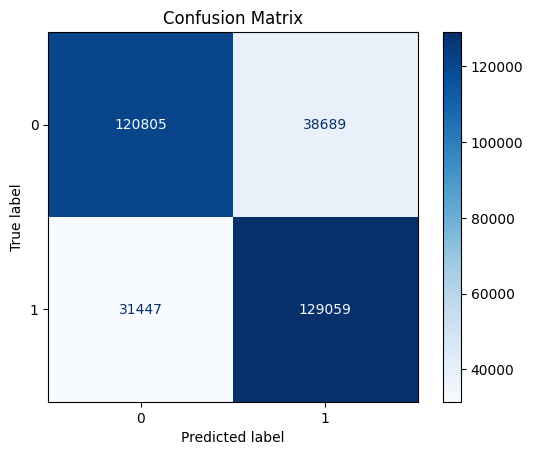

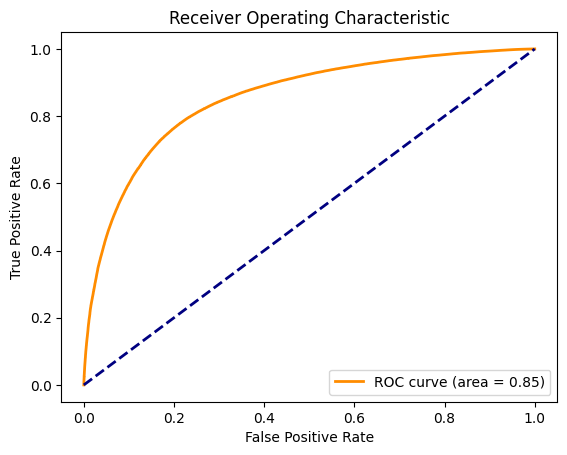

In [64]:
y_true, y_pred, y_probs = [], [], []
for inputs, labels in test_loader:
    inputs = inputs.to(device)
    outputs = model(inputs)
    y_probs.extend(torch.nn.functional.softmax(outputs, dim=1)[:, 1].detach().cpu().numpy())  # Fix applied
    _, predicted = torch.max(outputs, dim=1)
    y_true.extend(labels.numpy())
    y_pred.extend(predicted.cpu().numpy())

plot_confusion_matrix(y_true, y_pred)
plot_roc_curve(y_true, y_probs)
torch.save(model.state_dict(), 'Trained Model/SVM_model_BoW.pth')

## ---------------------------BoW with SVM Model---------------------------
- accuracy: 0.799154148312689

- precision: 0.8040990573817287

- recall: 0.7927840596387652

- f1_score: 0.7984014713014341

## TF-IDF

In [65]:
if __name__ == '__main__':
    df = pd.read_csv('dataset_tweets_preprocessed2.csv')
    df['target'] = df['target'].apply(lambda x: 0 if x == 0 else 1)
    df['processed_text_str'] = df['processed_text_str'].astype(str)

    vectorizer = TfidfVectorizer(max_features=10000, min_df=5, max_df=0.90)
    X = vectorizer.fit_transform(df['processed_text_str'])
    y = df['target'].values

    kfold = KFold(n_splits=5, shuffle=True, random_state=42)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    results = []

    for train_idx, test_idx in kfold.split(X):
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]

        train_dataset = SparseDataset(X_train, y_train)
        test_dataset = SparseDataset(X_test, y_test)

        train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
        test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

        model = SentimentSVM(X_train.shape[1])
        model.to(device)
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.SGD(model.parameters(), lr=0.01)
        scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)
        early_stopping = EarlyStopping(patience=5, verbose=True)

        train_model(model, train_loader, test_loader, criterion, optimizer, scheduler, device, 15, early_stopping)
        metrics = evaluate_metrics(model, test_loader, device)
        results.append(metrics)
        print(f"Fold Results: {metrics}")

c:\Users\panha\anaconda3\envs\cuda_gpu\lib\site-packages\torch\optim\lr_scheduler.py:232: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 1/15, Train Loss: 0.6420, Val Loss: 0.6062, Val Accuracy: 0.7374
Epoch 2/15, Train Loss: 0.5865, Val Loss: 0.5707, Val Accuracy: 0.7420
Epoch 3/15, Train Loss: 0.5601, Val Loss: 0.5510, Val Accuracy: 0.7487
Epoch 4/15, Train Loss: 0.5441, Val Loss: 0.5382, Val Accuracy: 0.7551
Epoch 5/15, Train Loss: 0.5332, Val Loss: 0.5290, Val Accuracy: 0.7577
Epoch 6/15, Train Loss: 0.5252, Val Loss: 0.5220, Val Accuracy: 0.7600
Epoch 7/15, Train Loss: 0.5189, Val Loss: 0.5166, Val Accuracy: 0.7628
Epoch 8/15, Train Loss: 0.5139, Val Loss: 0.5121, Val Accuracy: 0.7641
Epoch 9/15, Train Loss: 0.5098, Val Loss: 0.5083, Val Accuracy: 0.7654
Epoch 10/15, Train Loss: 0.5063, Val Loss: 0.5052, Val Accuracy: 0.7671
Epoch 11/15, Train Loss: 0.5033, Val Loss: 0.5024, Val Accuracy: 0.7680
Epoch 12/15, Train Loss: 0.5007, Val Loss: 0.5000, Val Accuracy: 0.7682
Epoch 13/15, Train Loss: 0.4983, Val Loss: 0.4979, Val Accuracy: 0.7695
Epoch 14/15, Train Loss: 0.4963, Val Loss: 0.4960, Val Accuracy: 0.7703
E

c:\Users\panha\anaconda3\envs\cuda_gpu\lib\site-packages\torch\optim\lr_scheduler.py:232: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 1/15, Train Loss: 0.6420, Val Loss: 0.6060, Val Accuracy: 0.7358
Epoch 2/15, Train Loss: 0.5867, Val Loss: 0.5704, Val Accuracy: 0.7465
Epoch 3/15, Train Loss: 0.5603, Val Loss: 0.5505, Val Accuracy: 0.7492
Epoch 4/15, Train Loss: 0.5443, Val Loss: 0.5376, Val Accuracy: 0.7551
Epoch 5/15, Train Loss: 0.5334, Val Loss: 0.5284, Val Accuracy: 0.7578
Epoch 6/15, Train Loss: 0.5254, Val Loss: 0.5214, Val Accuracy: 0.7599
Epoch 7/15, Train Loss: 0.5192, Val Loss: 0.5159, Val Accuracy: 0.7634
Epoch 8/15, Train Loss: 0.5141, Val Loss: 0.5114, Val Accuracy: 0.7644
Epoch 9/15, Train Loss: 0.5100, Val Loss: 0.5076, Val Accuracy: 0.7667
Epoch 10/15, Train Loss: 0.5065, Val Loss: 0.5045, Val Accuracy: 0.7682
Epoch 11/15, Train Loss: 0.5035, Val Loss: 0.5017, Val Accuracy: 0.7691
Epoch 12/15, Train Loss: 0.5009, Val Loss: 0.4993, Val Accuracy: 0.7706
Epoch 13/15, Train Loss: 0.4986, Val Loss: 0.4971, Val Accuracy: 0.7700
Epoch 14/15, Train Loss: 0.4966, Val Loss: 0.4952, Val Accuracy: 0.7712
E

c:\Users\panha\anaconda3\envs\cuda_gpu\lib\site-packages\torch\optim\lr_scheduler.py:232: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 1/15, Train Loss: 0.6420, Val Loss: 0.6064, Val Accuracy: 0.7376
Epoch 2/15, Train Loss: 0.5865, Val Loss: 0.5709, Val Accuracy: 0.7430
Epoch 3/15, Train Loss: 0.5600, Val Loss: 0.5512, Val Accuracy: 0.7506
Epoch 4/15, Train Loss: 0.5441, Val Loss: 0.5385, Val Accuracy: 0.7524
Epoch 5/15, Train Loss: 0.5331, Val Loss: 0.5292, Val Accuracy: 0.7574
Epoch 6/15, Train Loss: 0.5251, Val Loss: 0.5224, Val Accuracy: 0.7613
Epoch 7/15, Train Loss: 0.5188, Val Loss: 0.5170, Val Accuracy: 0.7633
Epoch 8/15, Train Loss: 0.5138, Val Loss: 0.5124, Val Accuracy: 0.7641
Epoch 9/15, Train Loss: 0.5097, Val Loss: 0.5088, Val Accuracy: 0.7639
Epoch 10/15, Train Loss: 0.5062, Val Loss: 0.5056, Val Accuracy: 0.7657
Epoch 11/15, Train Loss: 0.5032, Val Loss: 0.5028, Val Accuracy: 0.7674
Epoch 12/15, Train Loss: 0.5005, Val Loss: 0.5004, Val Accuracy: 0.7683
Epoch 13/15, Train Loss: 0.4982, Val Loss: 0.4983, Val Accuracy: 0.7693
Epoch 14/15, Train Loss: 0.4962, Val Loss: 0.4964, Val Accuracy: 0.7704
E

c:\Users\panha\anaconda3\envs\cuda_gpu\lib\site-packages\torch\optim\lr_scheduler.py:232: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 1/15, Train Loss: 0.6420, Val Loss: 0.6068, Val Accuracy: 0.7384
Epoch 2/15, Train Loss: 0.5864, Val Loss: 0.5714, Val Accuracy: 0.7415
Epoch 3/15, Train Loss: 0.5599, Val Loss: 0.5519, Val Accuracy: 0.7444
Epoch 4/15, Train Loss: 0.5439, Val Loss: 0.5390, Val Accuracy: 0.7535
Epoch 5/15, Train Loss: 0.5330, Val Loss: 0.5298, Val Accuracy: 0.7542
Epoch 6/15, Train Loss: 0.5250, Val Loss: 0.5228, Val Accuracy: 0.7586
Epoch 7/15, Train Loss: 0.5187, Val Loss: 0.5174, Val Accuracy: 0.7606
Epoch 8/15, Train Loss: 0.5137, Val Loss: 0.5129, Val Accuracy: 0.7618
Epoch 9/15, Train Loss: 0.5096, Val Loss: 0.5092, Val Accuracy: 0.7637
Epoch 10/15, Train Loss: 0.5061, Val Loss: 0.5060, Val Accuracy: 0.7647
Epoch 11/15, Train Loss: 0.5031, Val Loss: 0.5033, Val Accuracy: 0.7666
Epoch 12/15, Train Loss: 0.5004, Val Loss: 0.5009, Val Accuracy: 0.7668
Epoch 13/15, Train Loss: 0.4981, Val Loss: 0.4988, Val Accuracy: 0.7690
Epoch 14/15, Train Loss: 0.4961, Val Loss: 0.4969, Val Accuracy: 0.7699
E

c:\Users\panha\anaconda3\envs\cuda_gpu\lib\site-packages\torch\optim\lr_scheduler.py:232: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 1/15, Train Loss: 0.6420, Val Loss: 0.6066, Val Accuracy: 0.7338
Epoch 2/15, Train Loss: 0.5865, Val Loss: 0.5712, Val Accuracy: 0.7435
Epoch 3/15, Train Loss: 0.5600, Val Loss: 0.5515, Val Accuracy: 0.7496
Epoch 4/15, Train Loss: 0.5441, Val Loss: 0.5387, Val Accuracy: 0.7535
Epoch 5/15, Train Loss: 0.5332, Val Loss: 0.5295, Val Accuracy: 0.7561
Epoch 6/15, Train Loss: 0.5251, Val Loss: 0.5226, Val Accuracy: 0.7584
Epoch 7/15, Train Loss: 0.5189, Val Loss: 0.5170, Val Accuracy: 0.7630
Epoch 8/15, Train Loss: 0.5139, Val Loss: 0.5125, Val Accuracy: 0.7649
Epoch 9/15, Train Loss: 0.5097, Val Loss: 0.5088, Val Accuracy: 0.7665
Epoch 10/15, Train Loss: 0.5062, Val Loss: 0.5056, Val Accuracy: 0.7667
Epoch 11/15, Train Loss: 0.5032, Val Loss: 0.5028, Val Accuracy: 0.7685
Epoch 12/15, Train Loss: 0.5006, Val Loss: 0.5004, Val Accuracy: 0.7694
Epoch 13/15, Train Loss: 0.4983, Val Loss: 0.4983, Val Accuracy: 0.7704
Epoch 14/15, Train Loss: 0.4962, Val Loss: 0.4964, Val Accuracy: 0.7709
E

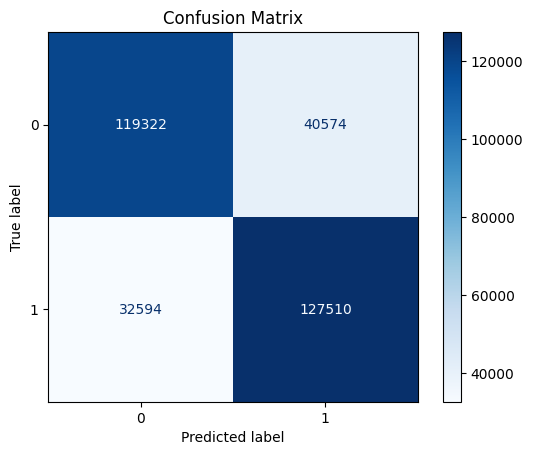

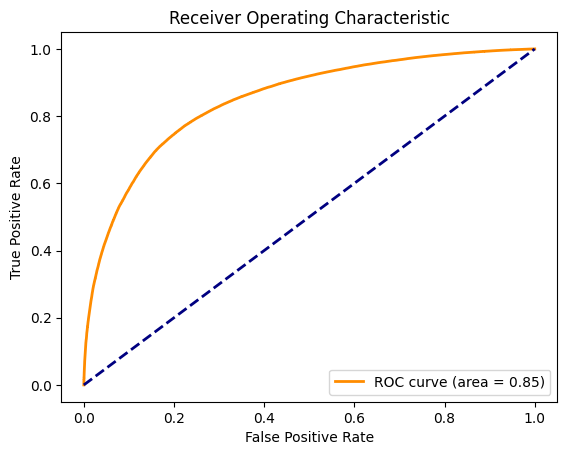

In [67]:
y_true, y_pred, y_probs = [], [], []
for inputs, labels in test_loader:
    inputs = inputs.to(device)
    outputs = model(inputs)
    y_probs.extend(torch.nn.functional.softmax(outputs, dim=1)[:, 1].detach().cpu().numpy())  # Fix applied
    _, predicted = torch.max(outputs, dim=1)
    y_true.extend(labels.numpy())
    y_pred.extend(predicted.cpu().numpy())

plot_confusion_matrix(y_true, y_pred)
plot_roc_curve(y_true, y_probs)
torch.save(model.state_dict(), 'Trained Model/SVM_model_TFIDF.pth')

## ---------------------------TF-IDF with SVM Model---------------------------

- accuracy: 0.7964998807775812 

- precision: 0.8036540476981672  

- recall: 0.7865049782358533 

- f1_score': 0.7949870409001834

# FeedForward Neural Network

In [ ]:
class SparseDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, idx):
        x_tensor = torch.FloatTensor(self.X[idx].toarray().squeeze(0))
        y_tensor = torch.tensor(self.y.iloc[idx], dtype=torch.long)
        return x_tensor, y_tensor

class TextClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dims, output_dim):
        super(TextClassifier, self).__init__()
        layers = []
        in_features = input_dim
        for hidden_dim in hidden_dims:
            layers.append(nn.Linear(in_features, hidden_dim))
            layers.append(nn.ReLU())
            layers.append(nn.BatchNorm1d(hidden_dim))
            layers.append(nn.Dropout(0.5))
            in_features = hidden_dim
        layers.append(nn.Linear(in_features, output_dim))
        self.network = nn.Sequential(*layers)

    def forward(self, x):
        return self.network(x)

def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, device, num_epochs=20):
    model.train()
    best_val_loss = float('inf')
    for epoch in range(num_epochs):
        total_loss = 0
        for texts, labels in train_loader:
            texts, labels = texts.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(texts)
            loss = criterion(outputs, labels)
            loss.backward()
            # Gradient clipping
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            total_loss += loss.item()

        # Validation phase
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for texts, labels in val_loader:
                texts, labels = texts.to(device), labels.to(device)
                outputs = model(texts)
                v_loss = criterion(outputs, labels)
                val_loss += v_loss.item()

        # Learning rate scheduling
        scheduler.step(val_loss)

        # Early stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), 'best_model.pth')
        else:
            print("Validation loss did not improve, stopping...")
            break

        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {total_loss/len(train_loader):.4f}, Val Loss: {val_loss/len(val_loader):.4f}')

def evaluate_model(model, test_loader, device):
    model.eval()
    y_all_preds = []
    y_all_tests = []
    y_scores = []
    
    with torch.no_grad():
        for texts, labels in test_loader:
            texts, labels = texts.to(device), labels.to(device)
            outputs = model(texts)
            probabilities = torch.nn.functional.softmax(outputs, dim=1)
            _, predicted = torch.max(outputs, 1)
            y_scores.extend(probabilities[:, 1].tolist())
            y_all_preds.extend(predicted.tolist())
            y_all_tests.extend(labels.tolist())

    accuracy = accuracy_score(y_all_tests, y_all_preds)
    precision = precision_score(y_all_tests, y_all_preds, average='binary')
    recall = recall_score(y_all_tests, y_all_preds, average='binary')
    f1 = f1_score(y_all_tests, y_all_preds, average='binary')

    metrics = {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1
    }
    
    return y_all_preds, y_scores, y_all_tests, metrics

def plot_roc_curve(y_test, y_score):
    fpr, tpr, _ = roc_curve(y_test, y_score)
    roc_auc = auc(fpr, tpr)
    
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.show()

def plot_confusion_matrix(y_test, y_pred):
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.show()

In [ ]:
df = pd.read_csv('dataset_tweets_preprocessed2.csv')
df['target'] = df['target'].apply(lambda x: 0 if x==0 else 1)
df['processed_text_str'] = df['processed_text_str'].astype(str)
texts = df['processed_text_str']
labels = df['target']

## BoW

In [ ]:
if __name__ == '__main__':
    df = pd.read_csv('dataset_tweets_preprocessed2.csv')
    df['target'] = df['target'].apply(lambda x: 0 if x==0 else 1)
    df['processed_text_str'] = df['processed_text_str'].astype(str)
    texts = df['processed_text_str']
    labels = df['target']

    vectorizer_bow = CountVectorizer(max_features=10000, min_df=5, max_df=0.90)
    X = vectorizer_bow.fit_transform(texts)
    X_train, X_test, y_train, y_test = train_test_split(X, labels, test_size=0.2, random_state=42)

    train_dataset = SparseDataset(X_train, y_train)
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

    test_dataset = SparseDataset(X_test, y_test)
    test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    model = TextClassifier(10000, [256, 128], 2).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=3)

    train_model(model, train_loader, test_loader, criterion, optimizer, scheduler, device, num_epochs=20)
    torch.save(model.state_dict(), 'Trained Model/BoW_FFNN_model.pth')
    predictions, scores, test_labels, performance_metrics = evaluate_model(model, test_loader, device)
    print(performance_metrics)
    
    plot_roc_curve(test_labels, scores)
    plot_confusion_matrix(test_labels, predictions)

## ---------------------------- BoW with FeedForward Neural Network ---------------------------- 

- accuracy: 0.801659375

- precision: 0.8134614266424607

- recall : 0.7844566558259505

- f1_score: 0.7986957997266001

## TF-IDF

In [ ]:
if __name__ == '__main__':
    df = pd.read_csv('dataset_tweets_preprocessed2.csv')
    df['target'] = df['target'].apply(lambda x: 0 if x==0 else 1)
    df['processed_text_str'] = df['processed_text_str'].astype(str)
    texts = df['processed_text_str']
    labels = df['target']

    tfidf_vectorizer  = TfidfVectorizer(max_features=10000, min_df=5, max_df=0.90)
    X = tfidf_vectorizer.fit_transform(texts)
    X_train, X_test, y_train, y_test = train_test_split(X, labels, test_size=0.2, random_state=42)

    train_dataset = SparseDataset(X_train, y_train)
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

    test_dataset = SparseDataset(X_test, y_test)
    test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    model = TextClassifier(10000, [256, 128], 2).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=3)

    train_model(model, train_loader, test_loader, criterion, optimizer, scheduler, device, num_epochs=20)
    torch.save(model.state_dict(), 'Trained Model/TFIDF_FFNN_model.pth')

    predictions, scores, test_labels, performance_metrics = evaluate_model(model, test_loader, device)
    print(performance_metrics)
    
    plot_roc_curve(test_labels, scores)
    plot_confusion_matrix(test_labels, predictions)

## ---------------------------- TF-IDF with FeedForward Neural Network ---------------------------- 

- accuracy: 0.800615625

- precision: 0.7868691003803049

- recall: 0.8262993283740172

- f1_score: 0.8061023233198097

# Long Short-Term Memory

In [12]:
class LSTMClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim, dropout_prob=0.5):
        super(LSTMClassifier, self).__init__()
        self.hidden_dim = hidden_dim
        self.layer_dim = layer_dim
        self.lstm = nn.LSTM(input_dim, hidden_dim, layer_dim, batch_first=True, dropout=dropout_prob)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        h0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim).to(x.device)
        c0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim).to(x.device)
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

class SparseDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = np.array(y)

    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, idx):
        x_tensor = torch.FloatTensor(self.X[idx].toarray())
        y_tensor = torch.tensor(self.y[idx], dtype=torch.long)
        return x_tensor, y_tensor

class EarlyStopping:
    def __init__(self, patience=5, verbose=False, delta=0):
        self.patience = patience
        self.verbose = verbose
        self.delta = delta
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.inf
        self.counter = 0

    def __call__(self, val_loss, model):
        score = -val_loss
        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            if self.verbose:
                print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        if self.verbose:
            print(f'Validation loss decreased ({self.val_loss_min:.6f} to {val_loss:.6f}). Saving model...')
        torch.save(model.state_dict(), 'checkpoint_LSTM_model.pth')
        self.val_loss_min = val_loss

def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, device, epochs, early_stopping):
    for epoch in range(epochs):
        model.train()
        total_loss = 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        val_loss = validate_model(model, val_loader, criterion, device)
        scheduler.step(val_loss)

        print(f'Epoch {epoch+1}, Loss: {total_loss / len(train_loader)}, Val Loss: {val_loss}')

        early_stopping(val_loss, model)
        if early_stopping.early_stop:
            print("Early stopping")
            break

    if not early_stopping.early_stop:
        print("Training completed without early stopping.")

def validate_model(model, val_loader, criterion, device):
    model.eval()
    total_val_loss = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            total_val_loss += loss.item()

    return total_val_loss / len(val_loader)

def evaluate_model(model, test_loader, device):
    model.eval()
    all_preds = []
    all_labels = []
    all_scores = []
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_scores.extend(outputs.softmax(dim=1)[:, 1].cpu().numpy())

    accuracy = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds)
    recall = recall_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds)
    roc_auc = roc_auc_score(all_labels, all_scores)
    print(f'Accuracy: {accuracy}, Precision: {precision}, Recall: {recall}, F1 Score: {f1}, ROC AUC: {roc_auc}')
    plot_roc_curve(all_labels, all_scores)
    plot_confusion_matrix(all_labels, all_preds)

def plot_roc_curve(y_true, y_scores):
    fpr, tpr, _ = roc_curve(y_true, y_scores)
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % auc(fpr, tpr))
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.show()

def plot_confusion_matrix(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.show()

def save_model(model, optimizer, scheduler, filename):
    torch.save({
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'scheduler_state_dict': scheduler.state_dict()
    }, filename)
    print("Model saved to", filename)

## BoW

c:\Users\panha\anaconda3\envs\cuda_gpu\lib\site-packages\torch\nn\modules\rnn.py:88: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
c:\Users\panha\anaconda3\envs\cuda_gpu\lib\site-packages\torch\optim\lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1, Loss: 0.456152995287627, Val Loss: 0.44041829435527324
Validation loss decreased (inf to 0.440418). Saving model...
Epoch 2, Loss: 0.4220475350376219, Val Loss: 0.43567812378257514
Validation loss decreased (0.440418 to 0.435678). Saving model...
Epoch 3, Loss: 0.3971368171069771, Val Loss: 0.44088892716914413
EarlyStopping counter: 1 out of 5
Epoch 4, Loss: 0.36600991354584694, Val Loss: 0.45544416411817074
EarlyStopping counter: 2 out of 5
Epoch 5, Loss: 0.32086935034506026, Val Loss: 0.49899119061082603
EarlyStopping counter: 3 out of 5
Epoch 6, Loss: 0.2530635498650372, Val Loss: 0.5588354591883719
EarlyStopping counter: 4 out of 5
Epoch 7, Loss: 0.23907192670544608, Val Loss: 0.5876474664129316
EarlyStopping counter: 5 out of 5
Early stopping
Accuracy: 0.789290625, Precision: 0.7862894544201868, Recall: 0.7963565224976014, F1 Score: 0.7912909706036209, ROC AUC: 0.860037285644784


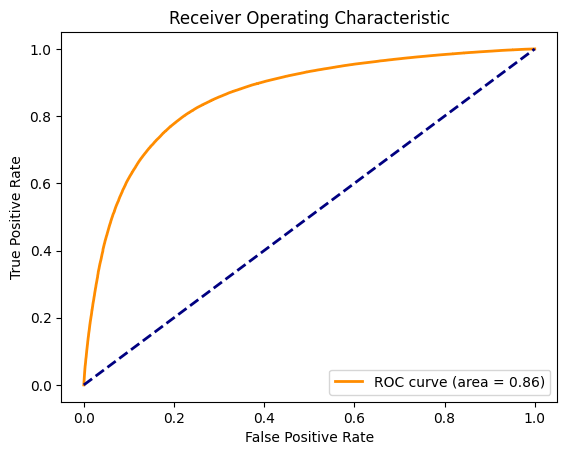

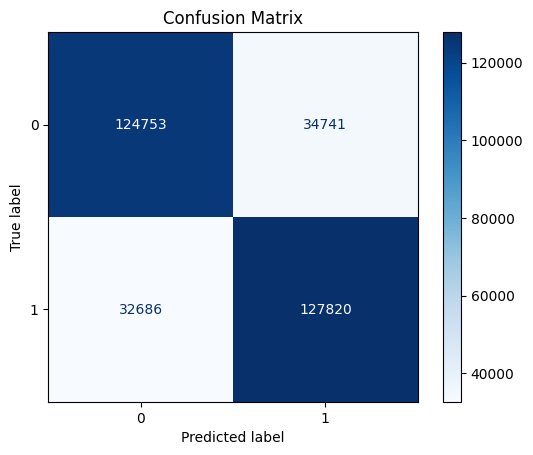

Model saved to BoW_lstm_model.pth


In [13]:
if __name__ == '__main__':
    df = pd.read_csv('dataset_tweets_preprocessed2.csv')
    df['target'] = df['target'].apply(lambda x: 0 if x == 0 else 1)
    df['processed_text_str'] = df['processed_text_str'].astype(str)

    vectorizer = CountVectorizer(max_features=10000, min_df=5, max_df=0.90)
    X = vectorizer.fit_transform(df['processed_text_str'])
    y = df['target']

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    train_dataset = SparseDataset(X_train, y_train)
    test_dataset = SparseDataset(X_test, y_test)

    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = LSTMClassifier(input_dim=10000, hidden_dim=128, layer_dim=1, output_dim=2).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    scheduler = ReduceLROnPlateau(optimizer, 'min', patience=2, factor=0.1, verbose=True)
    early_stopping = EarlyStopping(patience=5, verbose=True)

    train_model(model, train_loader, test_loader, criterion, optimizer, scheduler, device, 10, early_stopping)
    evaluate_model(model, test_loader, device)
    save_model(model.state_dict(), optimizer, scheduler, "Trained Model/BoW_lstm_model.pth")

## TF-IDF

c:\Users\panha\anaconda3\envs\cuda_gpu\lib\site-packages\torch\nn\modules\rnn.py:88: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
c:\Users\panha\anaconda3\envs\cuda_gpu\lib\site-packages\torch\optim\lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1, Loss: 0.4560229027438909, Val Loss: 0.43961925003528596
Validation loss decreased (inf to 0.439619). Saving model...
Epoch 2, Loss: 0.42182587992660703, Val Loss: 0.43505288520008323
Validation loss decreased (0.439619 to 0.435053). Saving model...
Epoch 3, Loss: 0.3977225656438619, Val Loss: 0.4388252083554864
EarlyStopping counter: 1 out of 5
Epoch 4, Loss: 0.36752926896251736, Val Loss: 0.4556550968103111
EarlyStopping counter: 2 out of 5
Epoch 5, Loss: 0.32353140534209085, Val Loss: 0.49114817880541084
EarlyStopping counter: 3 out of 5
Epoch 6, Loss: 0.25581408186312765, Val Loss: 0.5549746464192867
EarlyStopping counter: 4 out of 5
Epoch 7, Loss: 0.24103852501027287, Val Loss: 0.583287415087223
EarlyStopping counter: 5 out of 5
Early stopping
Accuracy: 0.78855, Precision: 0.7832932589618093, Recall: 0.7996710403349407, F1 Score: 0.7913974251467468, ROC AUC: 0.8594953843656341


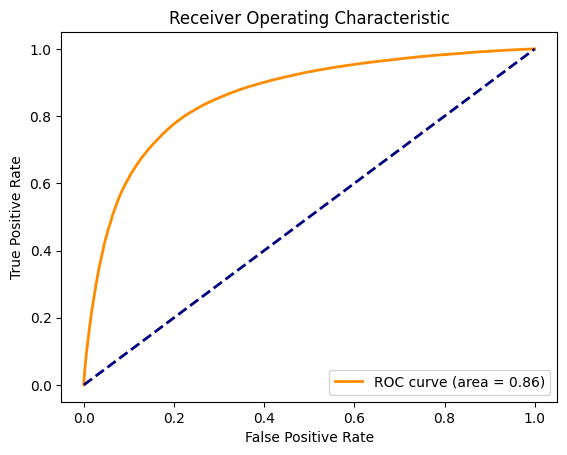

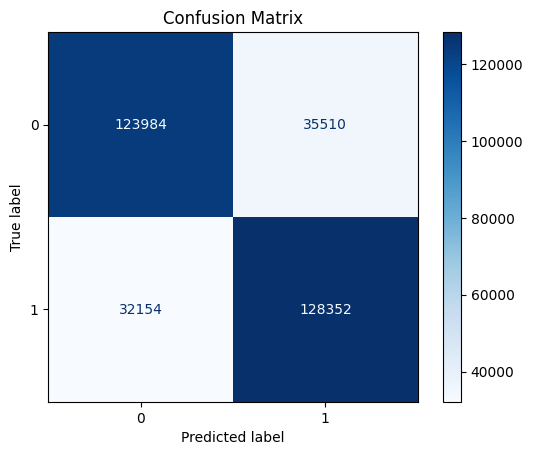

Model saved to TFIDF_lstm_model.pth


In [ ]:
if __name__ == '__main__':
    df = pd.read_csv('dataset_tweets_preprocessed2.csv')
    df['target'] = df['target'].apply(lambda x: 0 if x == 0 else 1)
    df['processed_text_str'] = df['processed_text_str'].astype(str)

    tfidf_vectorizer  = TfidfVectorizer(max_features=10000, min_df=5, max_df=0.90)
    X = vectorizer.fit_transform(df['processed_text_str'])
    y = df['target']

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    train_dataset = SparseDataset(X_train, y_train)
    test_dataset = SparseDataset(X_test, y_test)

    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = LSTMClassifier(input_dim=10000, hidden_dim=128, layer_dim=1, output_dim=2).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    scheduler = ReduceLROnPlateau(optimizer, 'min', patience=2, factor=0.1, verbose=True)
    early_stopping = EarlyStopping(patience=5, verbose=True)

    train_model(model, train_loader, test_loader, criterion, optimizer, scheduler, device, 10, early_stopping)
    evaluate_model(model, test_loader, device)

    save_model(model.state_dict(), optimizer, scheduler, "Trained Model/TFIDF_lstm_model.pth")